In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow as tf

In [2]:
# Import all the necessary files!
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
local_weights_file = '/data/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'



In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O $local_weights_file

In [9]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               include_top=False,
                               weights=None)

In [11]:
# Load the pre-trained weights 
pre_trained_model.load_weights(local_weights_file)

In [12]:
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [13]:
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [14]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [15]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [16]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(units=1024,activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(units=1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy',
              metrics = ['acc'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [17]:
BASE_PATH = '/data/tmp'
TRAINING_ZIP="horse-or-human.zip"
VALIDATION_ZIP="validation-horse-or-human.zip"
DATASET_DIR="horse-or-human"

In [ ]:
def extract_dataset(filename, dataset_dir):
  ''' will extract the dataset on the fullpath 
      to the BASE_PATH defined
      Args:
        fullpath (str): full path name to the zip file
  '''
  fullpath = os.path.join(BASE_PATH, filename)
  zip_ref = zipfile.ZipFile(fullpath, 'r')
  zip_ref.extractall(dataset_dir)
  zip_ref.close()

In [ ]:
def download_dataset(base_url,filename):
    url = "{}/{}".format(base_url, filename)
    path_to_download = os.path.join(BASE_PATH, filename)
    !wget $url -O $path_to_download

In [ ]:
base_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com"
# Get the Horse or Human dataset
download_dataset(base_url, TRAINING_ZIP)

# Get the Horse or Human Validation dataset
download_dataset(base_url, VALIDATION_ZIP)

In [18]:
train_dir = os.path.join(BASE_PATH, DATASET_DIR, "train")
validation_dir = os.path.join(BASE_PATH,DATASET_DIR, "validation")
train_horses_dir = os.path.join(train_dir, "horses")
train_humans_dir = os.path.join(train_dir, "humans")
validation_horses_dir = os.path.join(validation_dir, "horses")
validation_humans_dir = os.path.join(validation_dir, "humans")

In [19]:
# extract horses training 
extract_dataset(TRAINING_ZIP, train_dir)

# extract validation set
extract_dataset(VALIDATION_ZIP, validation_dir)

NameError: name 'extract_dataset' is not defined

In [20]:
train_horses_filenames = os.listdir(train_horses_dir)
train_humans_filenames = os.listdir(train_humans_dir)
validation_horses_filenames = os.listdir(validation_horses_dir)
validation_humans_filenames = os.listdir(validation_humans_dir)

for filenames_list in [train_horses_filenames, train_humans_filenames, 
                       validation_horses_filenames, validation_humans_filenames]:
    print(len(filenames_list))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [21]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  width_shift_range=0.2,
                                  rotation_range=45)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode = 'binary',
                                                    target_size=(150,150))
    
# Expected Output:
# Found 1027 images belonging to 2 classes.


Found 1027 images belonging to 2 classes.


In [22]:
# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

# Found 256 images belonging to 2 classes.

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                        class_mode = 'binary',
                                                         target_size=(150,150))

Found 256 images belonging to 2 classes.


In [23]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)

callbacks = myCallback()
history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              steps_per_epoch = 64,
                              epochs = 20,
                              validation_steps = 12,
                              verbose = 2)
                              

Epoch 1/20
64/64 - 20s - loss: 0.3003 - acc: 0.8773 - val_loss: 0.0097 - val_acc: 0.9958
Epoch 2/20
64/64 - 16s - loss: 0.0972 - acc: 0.9644 - val_loss: 0.2520 - val_acc: 0.9458
Epoch 3/20
64/64 - 16s - loss: 0.1096 - acc: 0.9496 - val_loss: 0.0355 - val_acc: 0.9833
Epoch 4/20
64/64 - 16s - loss: 0.0743 - acc: 0.9753 - val_loss: 0.0747 - val_acc: 0.9708
Epoch 5/20
64/64 - 16s - loss: 0.0422 - acc: 0.9814 - val_loss: 2.2974e-04 - val_acc: 1.0000
Epoch 6/20
64/64 - 16s - loss: 0.0588 - acc: 0.9739 - val_loss: 0.0096 - val_acc: 0.9958
Epoch 7/20
64/64 - 16s - loss: 0.0667 - acc: 0.9782 - val_loss: 0.0779 - val_acc: 0.9792
Epoch 8/20
64/64 - 16s - loss: 0.0671 - acc: 0.9802 - val_loss: 0.0542 - val_acc: 0.9875
Epoch 9/20
64/64 - 16s - loss: 0.0394 - acc: 0.9871 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 10/20
64/64 - 16s - loss: 0.0404 - acc: 0.9931 - val_loss: 0.0311 - val_acc: 0.9917
Epoch 11/20
64/64 - 18s - loss: 0.0727 - acc: 0.9792 - val_loss: 0.2055 - val_acc: 0.9667
Epoch 12/20
64/

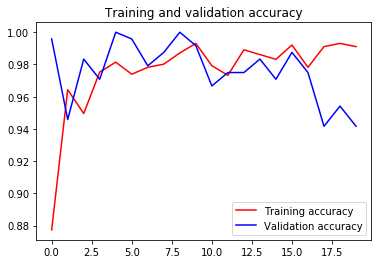

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()